In [5]:
%pylab inline
from PIL import Image
import os
from io import BytesIO
from keras.preprocessing import image
import cv2
import hashlib
import time

Populating the interactive namespace from numpy and matplotlib


(500, 375)


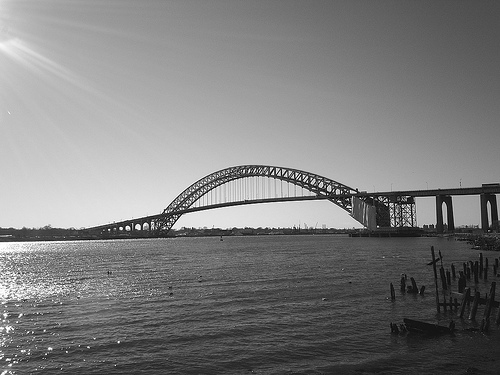

In [4]:
from PIL import Image
# '/home/imagenet-data/train//n03977966/n03977966_11273.JPEG'
image_path = '/home/imagenet-data/train//n13037406/n13037406_2574.JPEG'
image_path = '/home/imagenet-data/train//n04311004/n04311004_1560.JPEG'
image = Image.open(image_path)
print(image.size)
min(image.size)
image

('crop_size :', (340, 340))


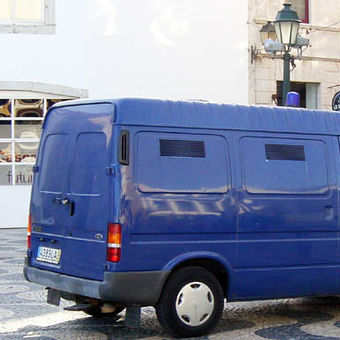

In [18]:
image_size = min(image.size)
crop_image = image.crop((0, 0, image_size, image_size))
print("crop_size :", crop_image.size)
crop_image

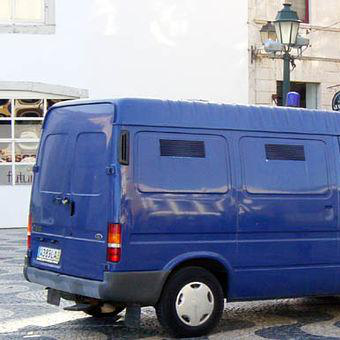

In [20]:

f = BytesIO()
crop_image.save(f, format='JPEG', quality=75)
bytes_content = f.getvalue()
crop_size = len(bytes_content)
f.seek(0)
img1 = Image.open(f)
img1

In [ ]:
    # DeepN-JPEG
    img_yuv = img1.convert('YCbCr')
    channels = img_yuv.split()

    rec_channels = []
    q_tables = []
    for channel in channels:
        # split and shift
        blocks = split_88(asarray(channel)) - 128
        # dct and get std_matrix
        dct_blocks = array([cv2.dct(item) for item in blocks])
        std_matrix = zeros([8, 8])
        for i in range(8):
            for j in range(8):
                std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)

        # Build Q-table
        q_table = zeros([8, 8], dtype=int64)
        a = 255
        b = 80
        c = 240
        T1 = 20
        T2 = 60
        k1 = 9.75
        k2 = 1
        k3 = 3
        Qmin = 5
        for i in range(8):
            for j in range(8):
                std_value = std_matrix[i, j]
                if std_value <= T1:
                    q = a - k1 * std_value
                elif std_value > T2:
                    q = c - k3 * std_value
                else:
                    q = b - k2 * std_value
                q = (q if (q > Qmin) else Qmin)
                q_table[i, j] = q
        
        q_tables.append(q_table)

        # quantization by q-table and recovery from q-table
        quantizd_dct_blocks = np.round(array([block / q_table for block in dct_blocks]))
        rec_dct_blocks = array([block * q_table for block in quantizd_dct_blocks])
        # idct, round and shift
        idct_rec_blocks = np.round(array([cv2.idct(block) for block in rec_dct_blocks])) + 128
        # merge into an image
        rec_channel = merge_88(idct_rec_blocks)
        
        rec_channels.append(clip(rec_channel, 0, 255))

    rec_channels = array(rec_channels, dtype=uint8)

    pil_channels = [Image.fromarray(channel) for channel in rec_channels]

    # image and compress image
    rec_image = Image.merge("YCbCr", channels).convert('RGB')
    rec_pil_image = Image.merge("YCbCr", pil_channels).convert('RGB')

    # compute file size
    rec_pil_image
    f2 = BytesIO()
    rec_pil_image.save(f2, format='JPEG', quality=75)#qtables=pil_qtables)
    rec_pil_image_size = len(f2.getvalue())

In [2]:
def split_88(image_data):
    blocks = []
    #image_size = image_data.shape[0]
    image_size = min(image_data.shape[0],image_data.shape[1])
    for i in range(int(image_size / 8)):
        row = image_data[8*i:8*(i+1), :]
        for j in range(int(image_size / 8)):
            col = row[:, 8*j:8*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_88(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 8*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def split_1616(image_data):
    blocks = []
    image_size = image_data.shape[0]
    for i in range(int(image_size / 16)):
        row = image_data[16*i:16*(i+1), :]
        for j in range(int(image_size / 16)):
            col = row[:, 16*j:16*(j+1)]
            blocks.append(col.astype(float32))
    return array(blocks)

def merge_1616(blocks):
    block_count = blocks.shape[0]
    edge_len = int(sqrt(block_count))
    img_size = 16*edge_len
    image_rows = []
    for i in range(edge_len):
        img_row = hstack(blocks[edge_len*i: edge_len*(i+1), ...])
        image_rows.append(img_row)
    return vstack(image_rows)

def zig_zag_flatten(a):
    return np.concatenate([np.diagonal(a[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-a.shape[0], a.shape[0])])

In [6]:
def image_generator(images_dir, target_size=None):
    count = 0
    while True:
        print("Data round %s" % count)
        for filename in os.listdir(images_dir):
            img = Image.open("%s/%s" % (images_dir, filename))
            print("%s/%s" % (images_dir, filename))
            if target_size is not None:
                img = img.resize(target_size)
#             img = image.load_img('%s/%s' % (images_dir, filename), target_size=target_size)

            f = BytesIO()
            img.save(f, format='JPEG', quality=75)
            bytes_content = f.getvalue()
            origin_file_size = len(bytes_content)
            yield img, origin_file_size
        count += 1

0
Data round 0
/home/imagenet-data/train/n03599486/n03599486_5319.JPEG
compress_rate : 0.5612250115036556
1
/home/imagenet-data/train/n03599486/n03599486_18852.JPEG
compress_rate : 0.6176738066213889
2
/home/imagenet-data/train/n03599486/n03599486_18022.JPEG
compress_rate : 0.6197699405890532
3
/home/imagenet-data/train/n03599486/n03599486_4481.JPEG
compress_rate : 0.7775952693823915
4
/home/imagenet-data/train/n03599486/n03599486_19483.JPEG
compress_rate : 0.3791758310163091
5
/home/imagenet-data/train/n03599486/n03599486_13315.JPEG
compress_rate : 0.6395035437393938
6
/home/imagenet-data/train/n03599486/n03599486_28080.JPEG
compress_rate : 0.5842680646996667
7
/home/imagenet-data/train/n03599486/n03599486_9505.JPEG
compress_rate : 0.598472920216552
8
/home/imagenet-data/train/n03599486/n03599486_11920.JPEG
compress_rate : 0.662301466096518
9
/home/imagenet-data/train/n03599486/n03599486_12180.JPEG
compress_rate : 0.6390295568132923
10
/home/imagenet-data/train/n03599486/n03599486_584

compress_rate : 0.5328050410540386
88
/home/imagenet-data/train/n03599486/n03599486_6397.JPEG
compress_rate : 0.5997569813613384
89
/home/imagenet-data/train/n03599486/n03599486_18196.JPEG
compress_rate : 0.5716049851812448
90
/home/imagenet-data/train/n03599486/n03599486_11494.JPEG
compress_rate : 0.3395725973319576
91
/home/imagenet-data/train/n03599486/n03599486_21550.JPEG
compress_rate : 0.6160090335776376
92
/home/imagenet-data/train/n03599486/n03599486_12637.JPEG
compress_rate : 0.4917007021708951
93
/home/imagenet-data/train/n03599486/n03599486_8270.JPEG
compress_rate : 0.6537489603992067
94
/home/imagenet-data/train/n03599486/n03599486_10436.JPEG
compress_rate : 0.4689353573941892
95
/home/imagenet-data/train/n03599486/n03599486_15312.JPEG
compress_rate : 0.44849853304953113
96
/home/imagenet-data/train/n03599486/n03599486_8621.JPEG
compress_rate : 0.6429530201342282
97
/home/imagenet-data/train/n03599486/n03599486_10159.JPEG
compress_rate : 0.6133147761540246
98
/home/imagenet

compress_rate : 0.6918799498230701
174
/home/imagenet-data/train/n03599486/n03599486_16161.JPEG
compress_rate : 0.5217238346525945
175
/home/imagenet-data/train/n03599486/n03599486_5939.JPEG
compress_rate : 0.5255281457391396
176
/home/imagenet-data/train/n03599486/n03599486_16618.JPEG
compress_rate : 0.7211563526406339
177
/home/imagenet-data/train/n03599486/n03599486_18092.JPEG
compress_rate : 0.4818947206796837
178
/home/imagenet-data/train/n03599486/n03599486_6226.JPEG
compress_rate : 0.6338252695240599
179
/home/imagenet-data/train/n03599486/n03599486_2137.JPEG
compress_rate : 0.6403415154749199
180
/home/imagenet-data/train/n03599486/n03599486_9657.JPEG
compress_rate : 0.4774030508164943
181
/home/imagenet-data/train/n03599486/n03599486_12771.JPEG
compress_rate : 0.6908369487017375
182
/home/imagenet-data/train/n03599486/n03599486_3277.JPEG
compress_rate : 0.5459489918416346
183
/home/imagenet-data/train/n03599486/n03599486_8794.JPEG
compress_rate : 0.4709800607408237
184
/home/i

compress_rate : 0.6223526862231329
260
/home/imagenet-data/train/n03599486/n03599486_9472.JPEG
compress_rate : 0.7041183799559659
261
/home/imagenet-data/train/n03599486/n03599486_13262.JPEG
compress_rate : 0.6749171270718232
262
/home/imagenet-data/train/n03599486/n03599486_13078.JPEG
compress_rate : 0.614312866705231
263
/home/imagenet-data/train/n03599486/n03599486_4389.JPEG
compress_rate : 0.6391391391391391
264
/home/imagenet-data/train/n03599486/n03599486_7359.JPEG
compress_rate : 0.6067900950980842
265
/home/imagenet-data/train/n03599486/n03599486_966.JPEG
compress_rate : 0.35425289989038494
266
/home/imagenet-data/train/n03599486/n03599486_5754.JPEG
compress_rate : 0.640710285673779
267
/home/imagenet-data/train/n03599486/n03599486_3715.JPEG
compress_rate : 0.4502189781021898
268
/home/imagenet-data/train/n03599486/n03599486_12898.JPEG
compress_rate : 0.5343362062149126
269
/home/imagenet-data/train/n03599486/n03599486_12732.JPEG
compress_rate : 0.5066666666666667
270
/home/ima

compress_rate : 0.485039052883647
346
/home/imagenet-data/train/n03599486/n03599486_17381.JPEG
compress_rate : 0.584334991893554
347
/home/imagenet-data/train/n03599486/n03599486_17018.JPEG
compress_rate : 0.6178990081154193
348
/home/imagenet-data/train/n03599486/n03599486_21080.JPEG
compress_rate : 0.6135807215264149
349
/home/imagenet-data/train/n03599486/n03599486_7208.JPEG
compress_rate : 0.7547388968654718
350
/home/imagenet-data/train/n03599486/n03599486_4295.JPEG
compress_rate : 0.3987233792210848
351
/home/imagenet-data/train/n03599486/n03599486_18442.JPEG
compress_rate : 0.5881363469383809
352
/home/imagenet-data/train/n03599486/n03599486_24518.JPEG
compress_rate : 0.6200904137373876
353
/home/imagenet-data/train/n03599486/n03599486_4276.JPEG
compress_rate : 0.783132334033169
354
/home/imagenet-data/train/n03599486/n03599486_8661.JPEG
compress_rate : 0.4989895928059008
355
/home/imagenet-data/train/n03599486/n03599486_15789.JPEG
compress_rate : 0.6131603074970026
356
/home/im

compress_rate : 0.5092221530802739
432
/home/imagenet-data/train/n03599486/n03599486_6279.JPEG
compress_rate : 0.6199911117694985
433
/home/imagenet-data/train/n03599486/n03599486_6412.JPEG
compress_rate : 0.6496188404841934
434
/home/imagenet-data/train/n03599486/n03599486_9137.JPEG
compress_rate : 0.6094281438483515
435
/home/imagenet-data/train/n03599486/n03599486_12018.JPEG
compress_rate : 0.5138192240761593
436
/home/imagenet-data/train/n03599486/n03599486_20657.JPEG
compress_rate : 0.615661018280351
437
/home/imagenet-data/train/n03599486/n03599486_13296.JPEG
compress_rate : 0.6869132826037821
438
/home/imagenet-data/train/n03599486/n03599486_10568.JPEG
compress_rate : 0.6310266473869035
439
/home/imagenet-data/train/n03599486/n03599486_17531.JPEG
compress_rate : 0.6262699858328273
440
/home/imagenet-data/train/n03599486/n03599486_13551.JPEG
compress_rate : 0.5392269312381717
441
/home/imagenet-data/train/n03599486/n03599486_28448.JPEG
compress_rate : 0.3535135375846099
442
/home

compress_rate : 0.6522551557437472
518
/home/imagenet-data/train/n03599486/n03599486_9008.JPEG
compress_rate : 0.6503259933571165
519
/home/imagenet-data/train/n03599486/n03599486_9291.JPEG
compress_rate : 0.6171181131380137
520
/home/imagenet-data/train/n03599486/n03599486_11833.JPEG
compress_rate : 0.8297343653795408
521
/home/imagenet-data/train/n03599486/n03599486_15066.JPEG
compress_rate : 0.44728355924792307
522
/home/imagenet-data/train/n03599486/n03599486_3832.JPEG
compress_rate : 0.5544857539049214
523
/home/imagenet-data/train/n03599486/n03599486_6478.JPEG
compress_rate : 0.5711379129522811
524
/home/imagenet-data/train/n03599486/n03599486_4994.JPEG
compress_rate : 0.749688118058725
525
/home/imagenet-data/train/n03599486/n03599486_24847.JPEG
compress_rate : 0.6423258958755916
526
/home/imagenet-data/train/n03599486/n03599486_16922.JPEG
compress_rate : 0.6265079437337825
527
/home/imagenet-data/train/n03599486/n03599486_10583.JPEG
compress_rate : 0.7508138987284751
528
/home/

compress_rate : 0.7230958717311456
604
/home/imagenet-data/train/n03599486/n03599486_3112.JPEG
compress_rate : 0.5228847941847689
605
/home/imagenet-data/train/n03599486/n03599486_7930.JPEG
compress_rate : 0.8801095659502739
606
/home/imagenet-data/train/n03599486/n03599486_18031.JPEG
compress_rate : 0.6216517000537263
607
/home/imagenet-data/train/n03599486/n03599486_13294.JPEG
compress_rate : 0.7804301075268817
608
/home/imagenet-data/train/n03599486/n03599486_2387.JPEG
compress_rate : 0.5322703992954972
609
/home/imagenet-data/train/n03599486/n03599486_15916.JPEG
compress_rate : 0.5257994080256199
610
/home/imagenet-data/train/n03599486/n03599486_11321.JPEG
compress_rate : 0.6652213478935817
611
/home/imagenet-data/train/n03599486/n03599486_20187.JPEG
compress_rate : 0.6310547491322184
612
/home/imagenet-data/train/n03599486/n03599486_5474.JPEG
compress_rate : 0.6241548071350377
613
/home/imagenet-data/train/n03599486/n03599486_18688.JPEG
compress_rate : 0.5930892782184124
614
/home

compress_rate : 0.5490125969525277
690
/home/imagenet-data/train/n03599486/n03599486_19614.JPEG
compress_rate : 0.5149364093463472
691
/home/imagenet-data/train/n03599486/n03599486_1493.JPEG
compress_rate : 0.522261935154455
692
/home/imagenet-data/train/n03599486/n03599486_8845.JPEG
compress_rate : 0.5681708922935435
693
/home/imagenet-data/train/n03599486/n03599486_13547.JPEG
compress_rate : 0.44647799327727916
694
/home/imagenet-data/train/n03599486/n03599486_7596.JPEG
compress_rate : 0.4698154699302037
695
/home/imagenet-data/train/n03599486/n03599486_6802.JPEG
compress_rate : 0.7231587950204315
696
/home/imagenet-data/train/n03599486/n03599486_12226.JPEG
compress_rate : 0.4829334881051584
697
/home/imagenet-data/train/n03599486/n03599486_17666.JPEG
compress_rate : 0.4701323861801744
698
/home/imagenet-data/train/n03599486/n03599486_19903.JPEG
compress_rate : 0.44945054945054946
699
/home/imagenet-data/train/n03599486/n03599486_2079.JPEG
compress_rate : 0.5698263386396527
700
/home

compress_rate : 0.5452762798515303
776
/home/imagenet-data/train/n03599486/n03599486_8129.JPEG
compress_rate : 0.4480529297558802
777
/home/imagenet-data/train/n03599486/n03599486_15052.JPEG
compress_rate : 0.6630806354313292
778
/home/imagenet-data/train/n03599486/n03599486_1773.JPEG
compress_rate : 0.5040829386919237
779
/home/imagenet-data/train/n03599486/n03599486_28827.JPEG
compress_rate : 0.47555660090310564
780
/home/imagenet-data/train/n03599486/n03599486_16929.JPEG
compress_rate : 0.5094925941887631
781
/home/imagenet-data/train/n03599486/n03599486_7992.JPEG
compress_rate : 0.4880263262231385
782
/home/imagenet-data/train/n03599486/n03599486_17539.JPEG
compress_rate : 0.7389522812046377
783
/home/imagenet-data/train/n03599486/n03599486_18772.JPEG
compress_rate : 0.6017414813124309
784
/home/imagenet-data/train/n03599486/n03599486_3444.JPEG
compress_rate : 0.5186574580145086
785
/home/imagenet-data/train/n03599486/n03599486_10874.JPEG
compress_rate : 0.6217483099928333
786
/hom

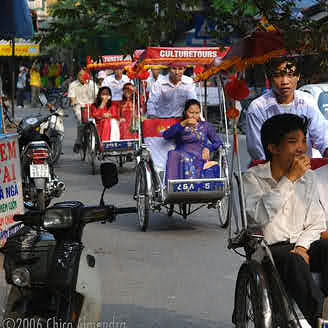

In [7]:
generator = image_generator('/home/imagenet-data/train/n03599486')
start = time.clock()
compress_rates = []
for i in range(800):
    print(i)
    origin_image, origin_image_size= next(generator)
    #print("origin_image_size :",origin_image_size)

    # DeepN-JPEG
    img_yuv = origin_image.convert('YCbCr')
    channels = img_yuv.split()

    rec_channels = []
    q_tables = []
    for channel in channels:
        # split and shift
        blocks = split_88(asarray(channel)) - 128
        # dct and get std_matrix
        dct_blocks = array([cv2.dct(item) for item in blocks])
        std_matrix = zeros([8, 8])
        for i in range(8):
            for j in range(8):
                std_matrix[i, j] = std(dct_blocks[:,i,j], ddof=1)

        # Build Q-table
        q_table = zeros([8, 8], dtype=int64)
        a = 255
        b = 80
        c = 240
        T1 = 20
        T2 = 60
        k1 = 9.75
        k2 = 1
        k3 = 3
        Qmin = 5
        for i in range(8):
            for j in range(8):
                std_value = std_matrix[i, j]
                if std_value <= T1:
                    q = a - k1 * std_value
                elif std_value > T2:
                    q = c - k3 * std_value
                else:
                    q = b - k2 * std_value
                q = (q if (q > Qmin) else Qmin)
                q_table[i, j] = q
        
        q_tables.append(q_table)

        # quantization by q-table and recovery from q-table
        quantizd_dct_blocks = np.round(array([block / q_table for block in dct_blocks]))
        rec_dct_blocks = array([block * q_table for block in quantizd_dct_blocks])
        # idct, round and shift
        idct_rec_blocks = np.round(array([cv2.idct(block) for block in rec_dct_blocks])) + 128
        # merge into an image
        rec_channel = merge_88(idct_rec_blocks)
        
        rec_channels.append(clip(rec_channel, 0, 255))

    rec_channels = array(rec_channels, dtype=uint8)

    pil_channels = [Image.fromarray(channel) for channel in rec_channels]

    # image and compress image
    rec_image = Image.merge("YCbCr", channels).convert('RGB')
    rec_pil_image = Image.merge("YCbCr", pil_channels).convert('RGB')

    # compute file size
    rec_pil_image
    f2 = BytesIO()
    rec_pil_image.save(f2, format='JPEG', quality=75)#qtables=pil_qtables)
    rec_pil_image_size = len(f2.getvalue())

    # compute compress_rate
    #print("rec_pil_image_size :",rec_pil_image_size)
    #print("origin_image_size :",origin_image_size)

    compress_rate = (rec_pil_image_size/origin_image_size)
    print("compress_rate :",compress_rate)
    compress_rates.append(compress_rate)
end = time.clock()
print("runing time",end-start)
rec_pil_image

In [9]:
print(len(compress_rates),mean(compress_rates))

800 0.5818337642193052


In [8]:
img = Image.open("/home/imagenet-data/train/n03085013/n03085013_21004.JPEG")
file_size(img,100)

NameError: name 'file_size' is not defined